# Imports

In [ ]:
! pip install huggingface transformers datasets

In [ ]:
from utils import tokenize, to_cuda, Logger, plot_results, HuggingMetric, freeze_model
from train import train_epoch, train_epoch_distil

import numpy as np

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import datasets

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm
import pickle

from IPython.display import clear_output
from typing import Tuple, List

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Settings

In [ ]:
MAX_LEN = 96
NUM_EPOCH = 4

# Описание задачи

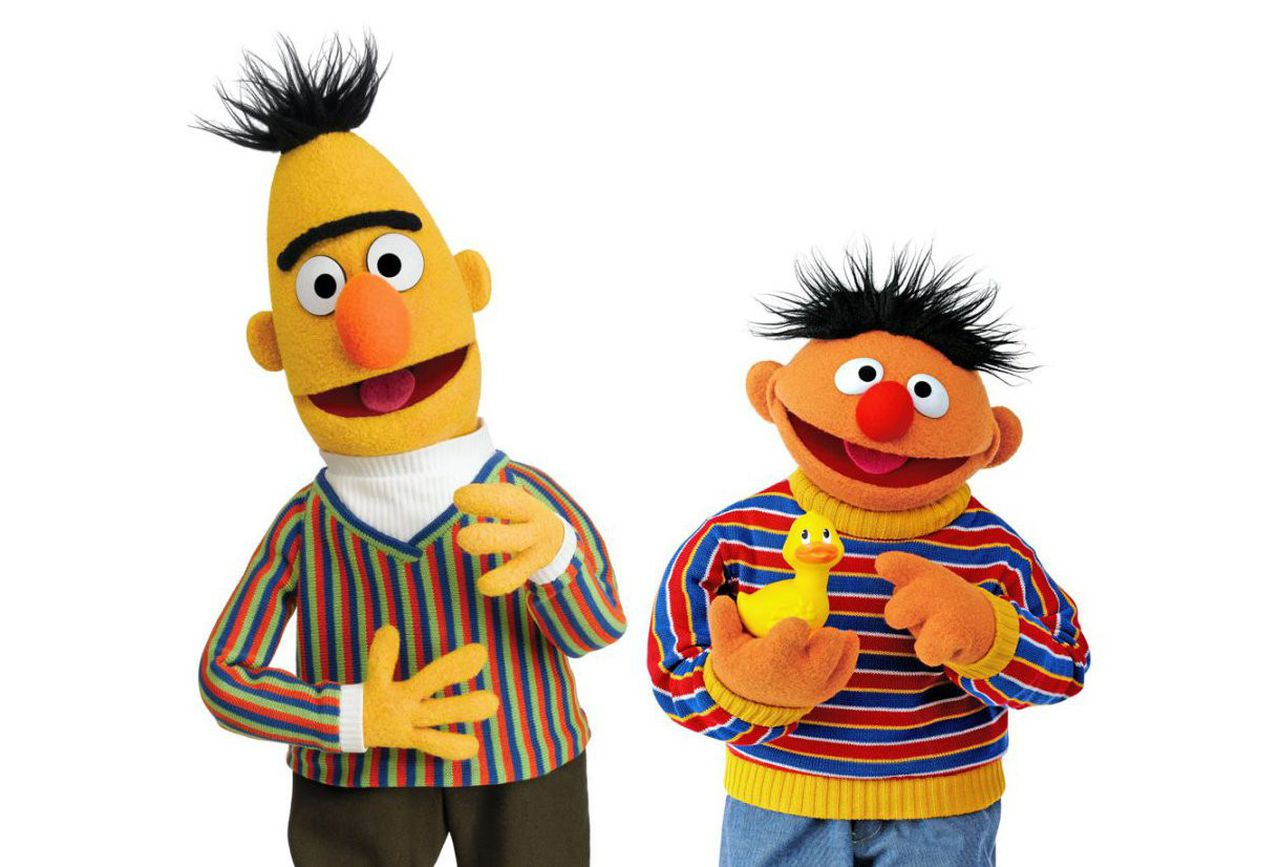

В данном ноутбуке мы решаем задачу классификации с помощью дообученных моделей трансформеров. Попытаемся по разному обучить модели и посмотрим к чему это приведёт. Модели возьмём из "младшего" разряда: небольшие и быстрые:
* DistilBert (256MB)
* DistilRoberta (316MB)
* Albert-base-V2 (46MB)

В качестве датасета возьмем один из бенчмарка [GLUE](https://gluebenchmark.com/) - [CoLA](https://nyu-mll.github.io/CoLA/). Этот датасет проверяет знание языка у модели, для каждого примера задача стоит так: является ли это предложение грамматически верным?. В качестве метрики предлагается использовать [Matthew's Correlation](http://www.machinelearning.ru/wiki/index.php?title=Корреляция_Мэтьюса).

Что мы попробуем?
* Зафайнтюнить всю модель
* Дообучить только слой классификатора
* Продистиллировать старшие модели Bert и Roberta, соответственно, в младшие DistilBert и DistilRoberta.

Что будем использовать? 
Во всю заиспользуем библиотеку [HuggingFace](huggingface.com). С ее помощью дообучим все предобученные модели.

# Важные вспомогательные функции

Остальные методы, используемые в ноутбуке можно найти в `train.py` и `utils.py`

In [ ]:
class ColaDataset(Dataset):
    def __init__(self, data) -> None:
        self.input_ids = torch.tensor(data['input_ids']).squeeze()
        self.attention_mask = torch.tensor(data['attention_mask']).squeeze()
        self.labels = torch.tensor(data['label']).squeeze()
        
    def __len__(self) -> int:
        return self.input_ids.shape[0]
    
    def __getitem__(self, idx: int) -> dict:
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [ ]:
def prepare_model(model_name: str, bs: int=32, drop: float=0.1):
    if 'distilbert' in model_name:
        dropout = {'dropout': drop}
    else:
        dropout = {'hidden_dropout_prob': drop}
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=dataset_train.features['label'].num_classes,
        **dropout
    ).cuda()

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    dataset_train_tokenized = dataset_train.map(
        tokenize, fn_kwargs={'tokenizer': tokenizer, 'MAX_LEN': MAX_LEN}, num_proc=2,
    )
    dataset_valid_tokenized = dataset_valid.map(
        tokenize, fn_kwargs={'tokenizer': tokenizer, 'MAX_LEN': MAX_LEN}, num_proc=2,
    )
    
    train_data = ColaDataset(dataset_train_tokenized)
    train_loader = DataLoader(train_data, batch_size=bs, num_workers=20, shuffle=True, pin_memory=True)

    valid_data = ColaDataset(dataset_valid_tokenized)
    valid_loader = DataLoader(valid_data, batch_size=16, num_workers=16, pin_memory=True)
    
    return model, train_loader, valid_loader

In [ ]:
dataset_train = datasets.load_dataset('glue', 'cola', split='train')
dataset_valid = datasets.load_dataset('glue', 'cola', split='validation')

matthew = datasets.load_metric('matthews_correlation')

Reusing dataset glue (/home/alexk/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/alexk/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [ ]:
def train_pipeline(
    name: str, 
    lr: float, 
    weight_decay: float, 
    bs: int, 
    drop: float, 
    value: float, 
    name_value: str, 
    loggers: dict
):
    
    model, train_loader, valid_loader = prepare_model(name, bs=bs, drop=drop)

    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                                step_size=100, 
                                                gamma=0.9)
    metric = HuggingMetric(matthew)
    logger = Logger(f'{name[:name.find('-')]} {name_value} = {value}')
    for epoch in range(NUM_EPOCH):
        train_epoch(
            model,
            optim,
            train_loader,
            valid_loader,
            logger,
            scheduler=scheduler,             
            metric=metric
        )
        clear_output()
    
    loggers[value] = logger

# Эксперименты

## Начнем с файнтюна и подберём LR

In [ ]:
distilbert_loggers = dict()

for lr in [2e-5, 1e-5, 7e-6, 5e-6]:
    train_pipeline(
        "distilbert-base-uncased", 
        lr=lr, 
        weight_decay = 1e-3, 
        bs=32, 
        drop=0.1, 
        value=lr,
        name_value='lr',
        distilbert_loggers
    )

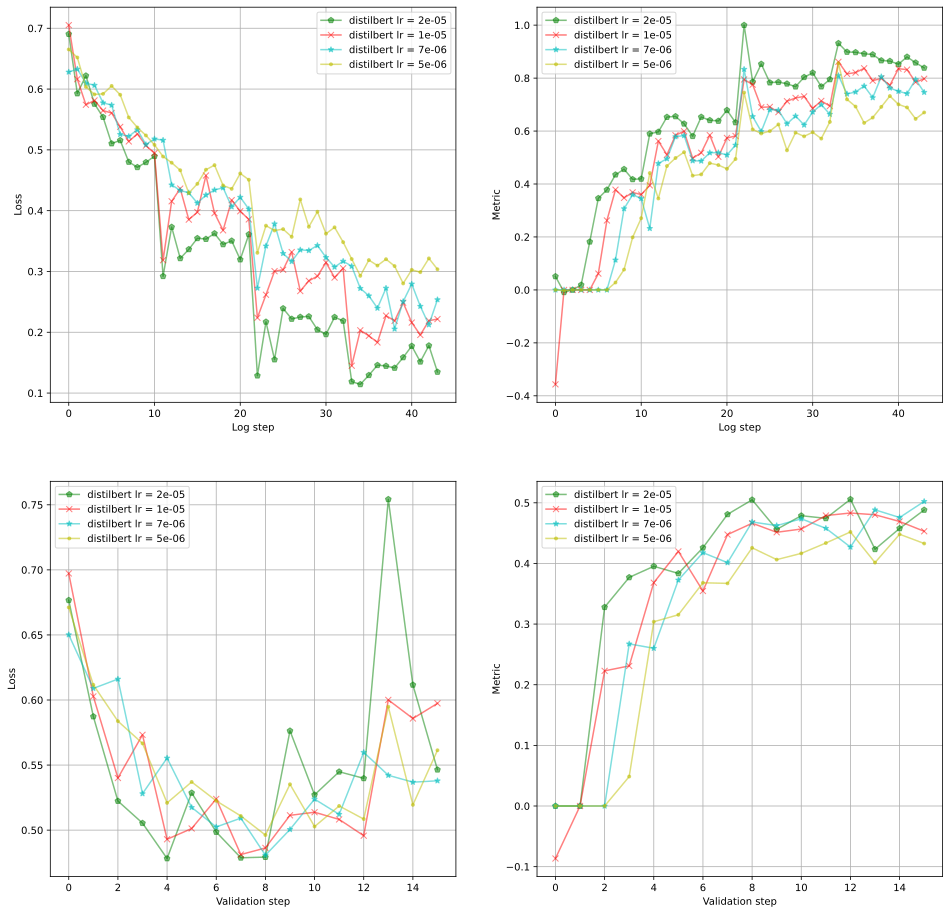

In [ ]:
plot_results(distilbert_loggers.values())

In [ ]:
distilroberta_loggers = dict()

for lr in [1e-5, 7e-6, 5e-6, 2e-6]:
    train_pipeline(
        "distilroberta-base", 
        lr = lr, 
        weight_decay = 1e-3, 
        bs = 32, 
        drop = 0.1, 
        value = lr,
        name_value = 'lr',
        loggers=distilroberta_loggers
    )

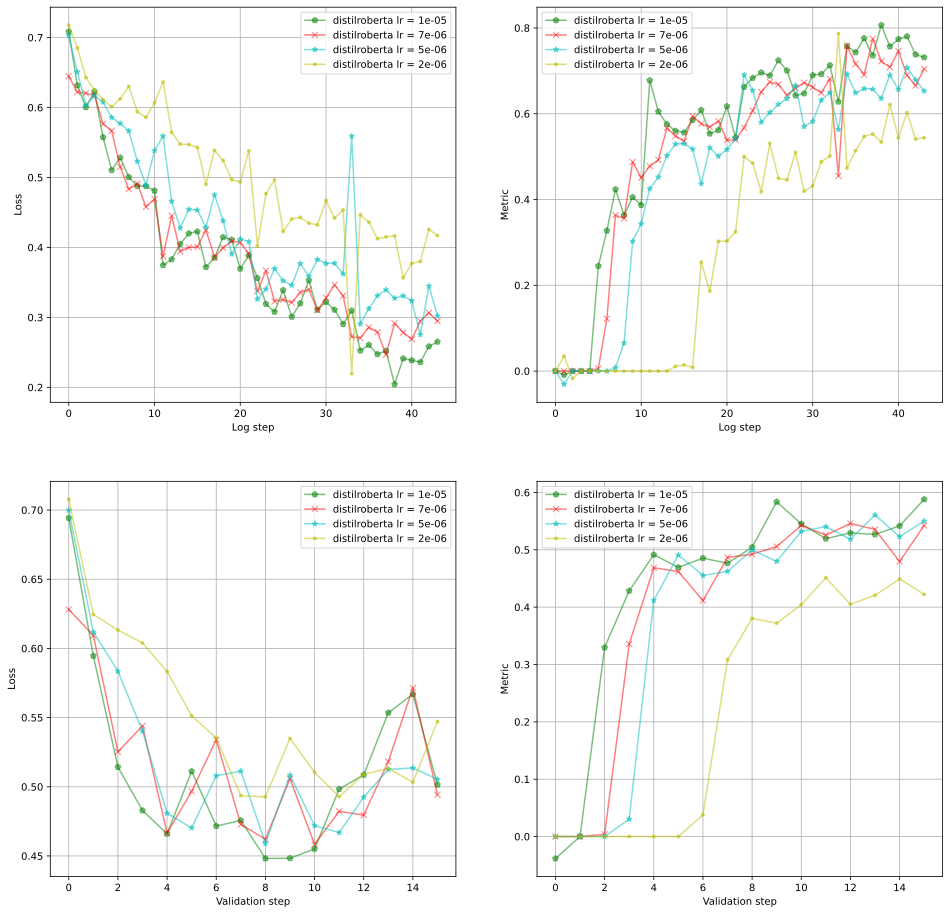

In [ ]:
plot_results(distilroberta_loggers.values())

In [ ]:
albert_loggers = dict()

for lr in [5e-5, 2e-5, 1e-5, 5e-6]:
    train_pipeline(
        name = "albert-base-v2", 
        lr = lr, 
        weight_decay = 1e-3, 
        bs = 32, 
        drop = 0.1, 
        value = lr,
        name_value = 'lr',
        loggers=albert_loggers
    )

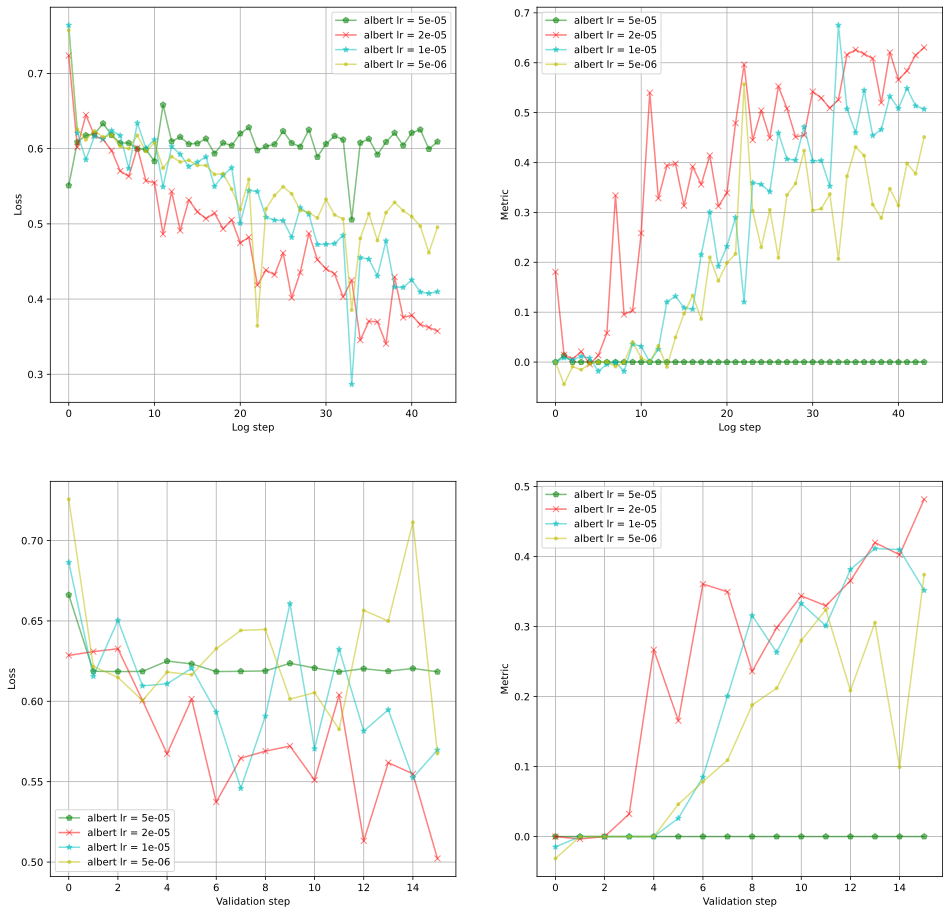

In [ ]:
plot_results(albert_loggers.values())

In [ ]:
with open('lr_distilbert_loggers','wb') as f:
    pickle.dump(distilbert_loggers, f )

In [ ]:
with open('lr_distilroberta_loggers','wb') as f:
    pickle.dump(distilroberta_loggers, f )

In [ ]:
with open('lr_albert_loggers','wb') as f:
    pickle.dump(albert_loggers, f )

## Подберем Weight Decay

In [ ]:
distilbert_loggers = dict()

for weight_decay in [1, 1e-2, 1e-3, 1e-4, 0]:
    train_pipeline(
        name = "distilbert-base-uncased", 
        lr = 1e-5
        weight_decay = weight_decay, 
        bs = 32, 
        drop = 0.1, 
        value = weight_decay,
        name_value = 'weight_decay',
        loggers=distilbert_loggers
    )

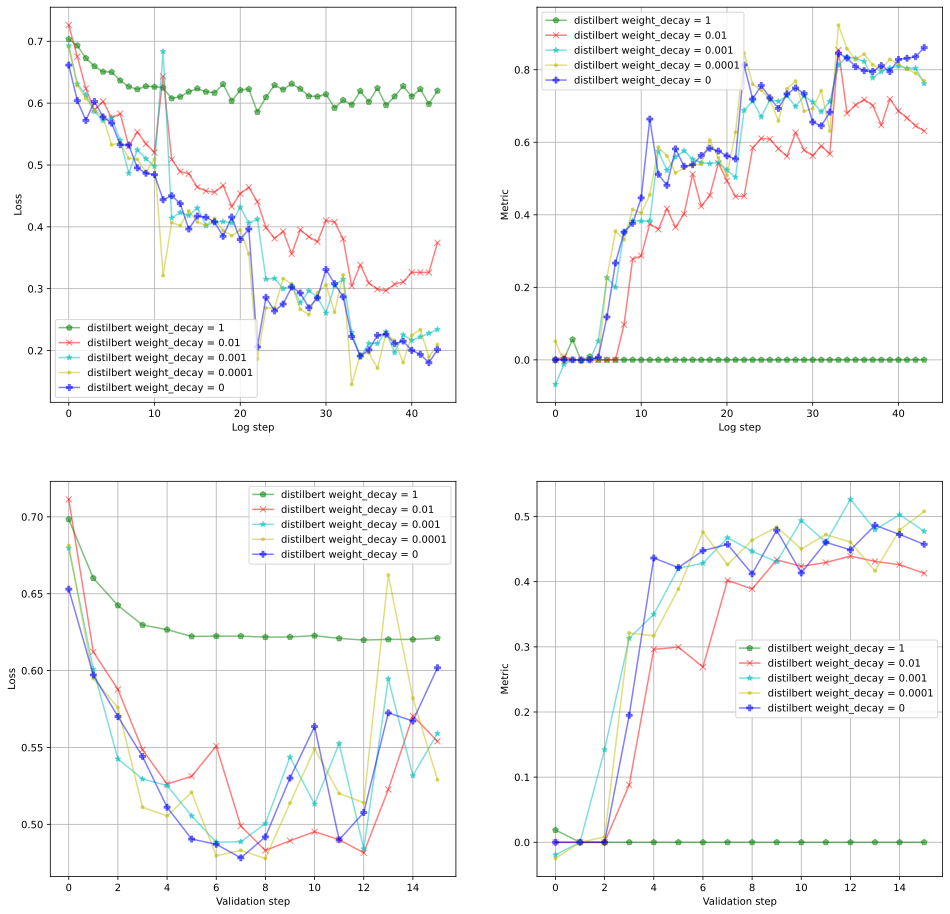

In [ ]:
plot_results(distilbert_loggers.values())

In [ ]:
distilroberta_loggers = dict()


for weight_decay in [1, 1e-2, 1e-3, 1e-4, 0]:
    train_pipeline(
        name = "distilroberta-base", 
        lr = 1e-5
        weight_decay = weight_decay, 
        bs = 32, 
        drop = 0.1, 
        value = weight_decay,
        name_value = 'weight_decay',
        loggers = distilroberta_loggers
    )

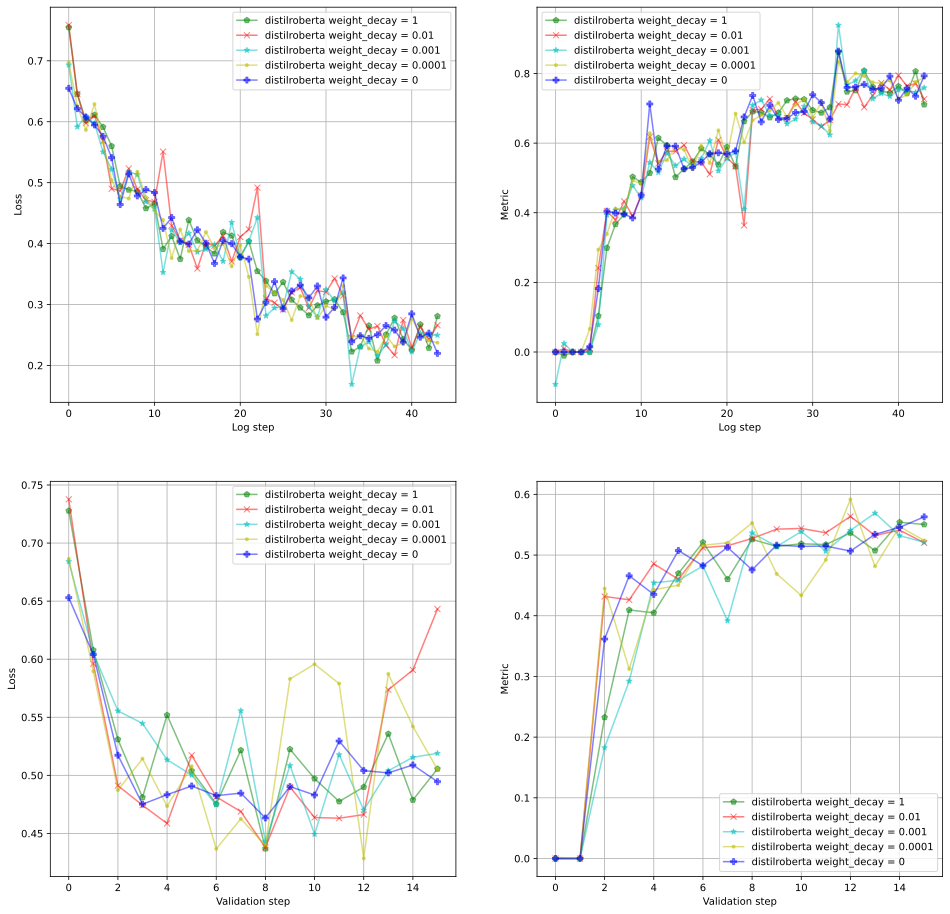

In [ ]:
plot_results(distilroberta_loggers.values())

In [ ]:
albert_loggers = dict()

for weight_decay in [1, 1e-2, 1e-3, 1e-4, 0]:
    train_pipeline(
        name = "albert-base-v2", 
        lr = 2e-5
        weight_decay = weight_decay, 
        bs = 32, 
        drop = 0.1, 
        value = weight_decay,
        name_value = 'weight_decay',
        loggers = albert_loggers
    )

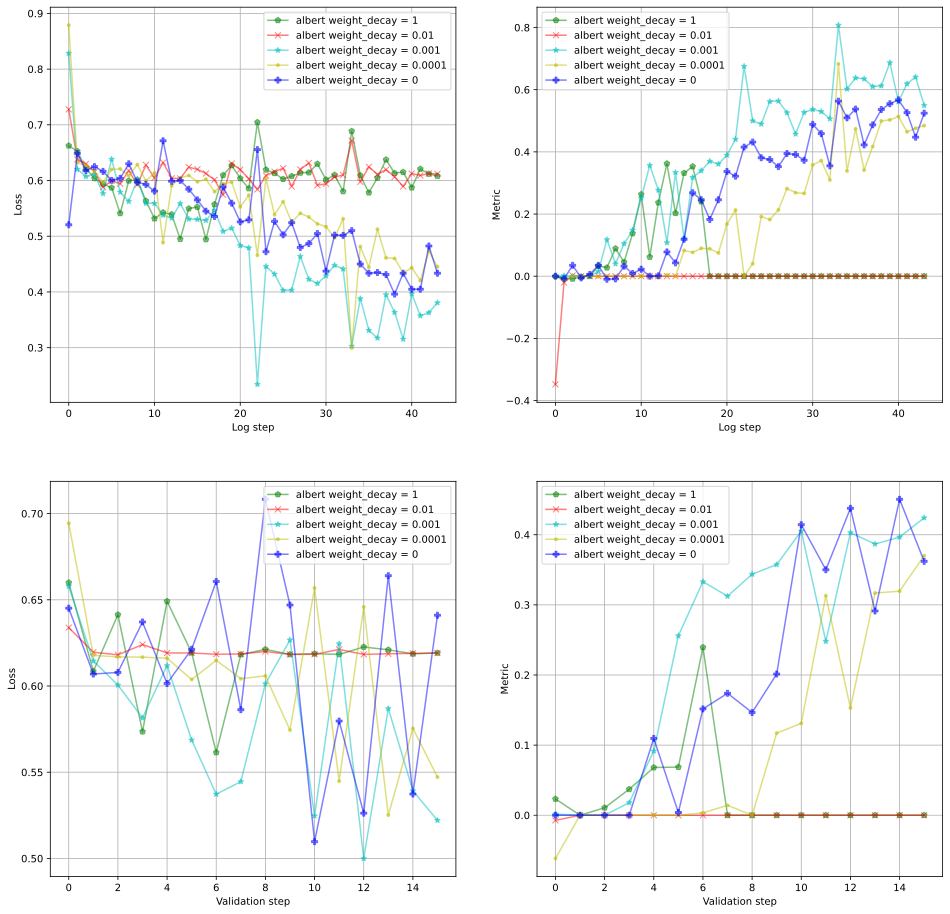

In [ ]:
plot_results(albert_loggers.values())

In [ ]:
with open('wd_distilbert_loggers','wb') as f:
    pickle.dump(distilbert_loggers, f )

In [ ]:
with open('wd_distilroberta_loggers','wb') as f:
    pickle.dump(distilroberta_loggers, f )

In [ ]:
with open('wd_albert_loggers','wb') as f:
    pickle.dump(albert_loggers, f )

## Подберем Batch size

In [ ]:
distilbert_loggers = dict()

for bs in [32, 64, 128]:
    train_pipeline(
        name = "distilbert-base-uncased", 
        lr = 1e-5
    weight_decay = 1e-3
        bs = bs, 
        drop = 0.1, 
        value = bs,
        name_value = 'batch_size',
        loggers = distilbert_loggers
    )

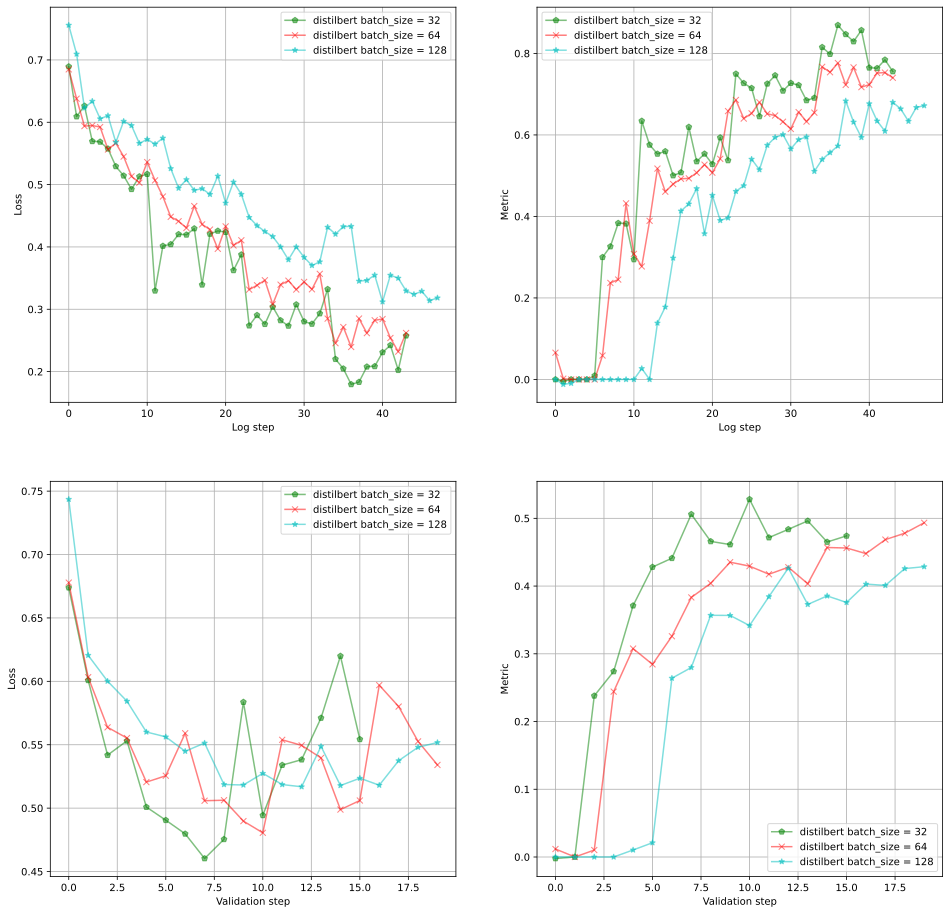

In [ ]:
plot_results(distilbert_loggers.values())

In [ ]:
distilroberta_loggers = dict()

for bs in [32, 64, 128]:
    train_pipeline(
        name = "distilroberta-base", 
        lr = 1e-5
    weight_decay = 1e-3
        bs = bs, 
        drop = 0.1, 
        value = bs,
        name_value = 'batch_size',
        loggers = distilroberta_loggers
    )

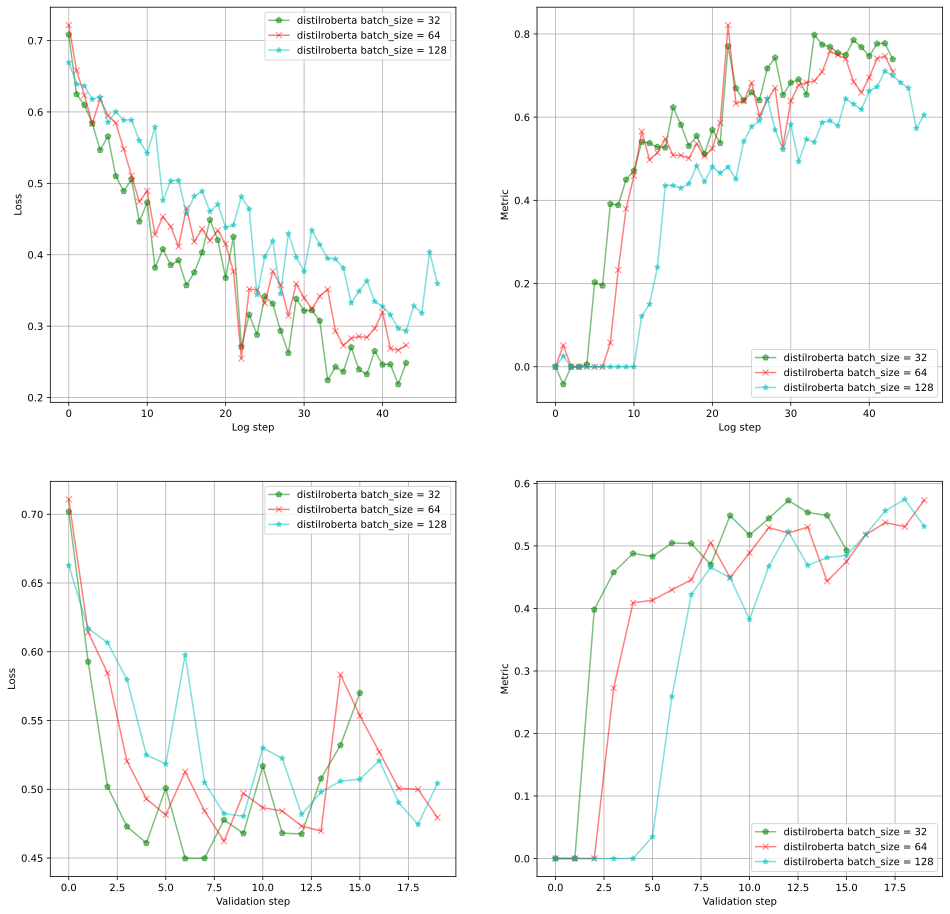

In [ ]:
plot_results(distilroberta_loggers.values())

In [ ]:
albert_loggers = dict()

for bs in [32, 64, 128]:
    train_pipeline(
        name = "albert-base-v2", 
        lr = 2e-5
    weight_decay = 1e-3
        bs = bs, 
        drop = 0.1, 
        value = bs,
        name_value = 'batch_size',
        loggers = albert_loggers
    )

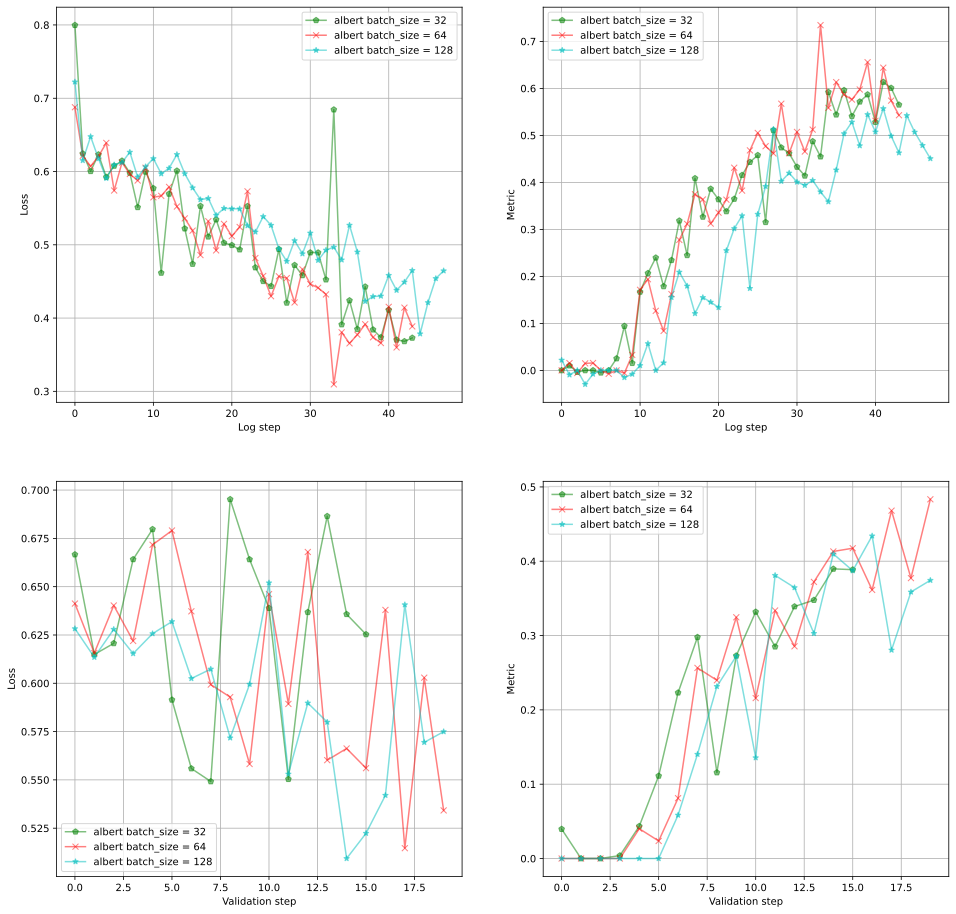

In [ ]:
plot_results(albert_loggers.values())

In [ ]:
with open('bs_distilbert_loggers','wb') as f:
    pickle.dump(distilbert_loggers, f )

In [ ]:
with open('bs_distilroberta_loggers','wb') as f:
    pickle.dump(distilroberta_loggers, f )

In [ ]:
with open('bs_albert_loggers','wb') as f:
    pickle.dump(albert_loggers, f )

## Подберем Dropout prob

In [ ]:
distilbert_loggers = dict()

for drop in [0, 0.05, 0.1, 0.15, 0.2]:
    train_pipeline(
        name = "distilbert-base-uncased", 
        lr = 1e-5
    weight_decay = 1e-3
        bs = 32, 
        drop = drop, 
        value = drop,
        name_value = 'dropout',
        loggers = distilbert_loggers
    )

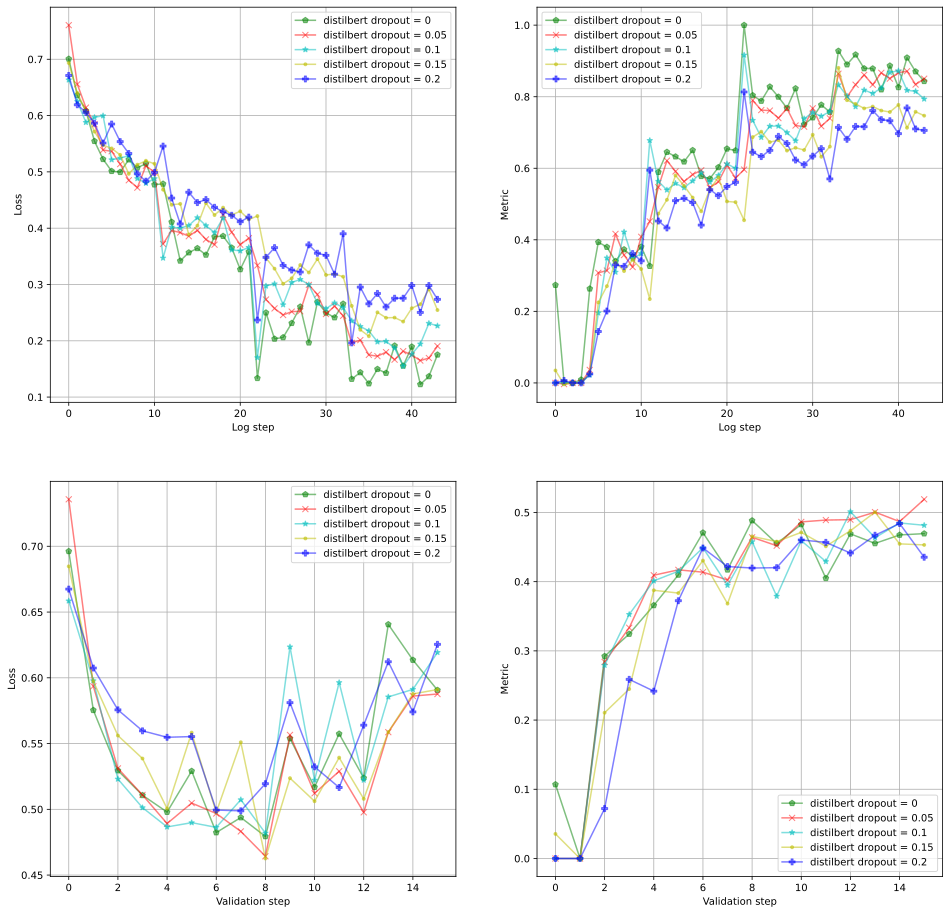

In [ ]:
plot_results(distilbert_loggers.values())

In [ ]:
distilroberta_loggers = dict()

for drop in [0, 0.05, 0.1, 0.15, 0.2]:
    train_pipeline(
        name = "distilroberta-base", 
        lr = 1e-5
    weight_decay = 1e-3
        bs = 64, 
        drop = drop, 
        value = drop,
        name_value = 'dropout',
        loggers = distilroberta_loggers
    )

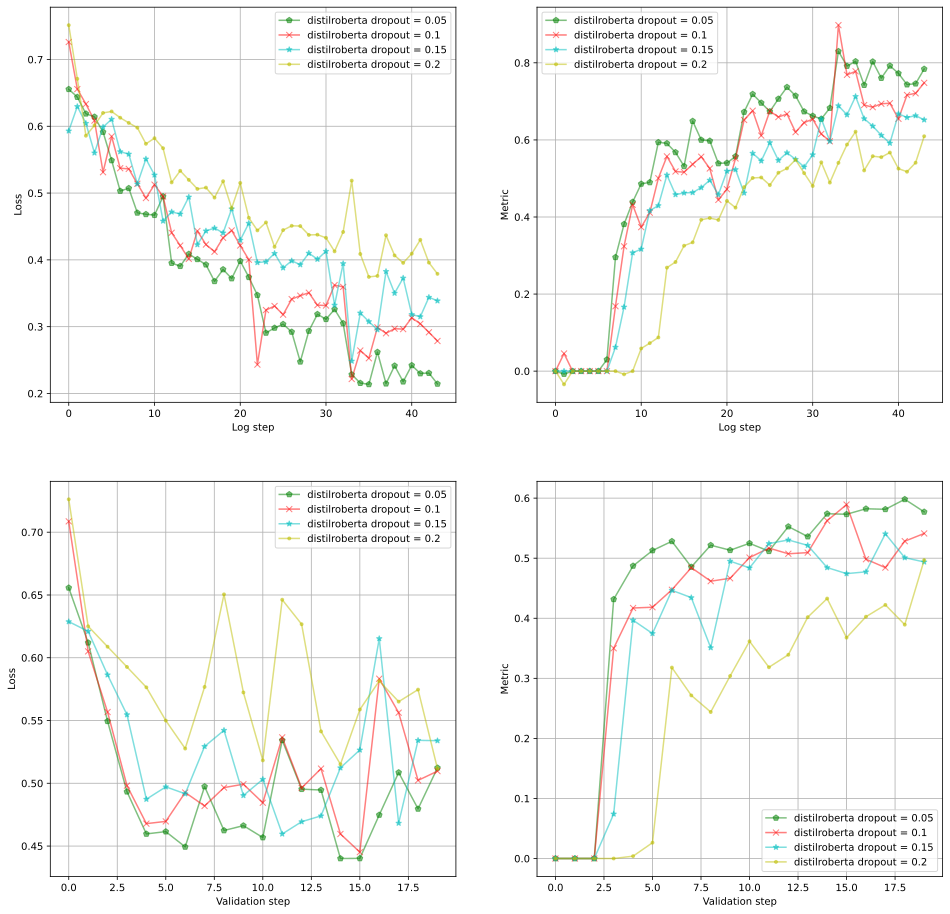

In [ ]:
plot_results(distilroberta_loggers.values())

In [ ]:
albert_loggers = dict()

for drop in [0, 0.005, 0.01, 0.1]:
    train_pipeline(
        name = "albert-base-v2", 
        lr = 2e-5
    weight_decay = 1e-3
        bs = 64, 
        drop = drop, 
        value = drop,
        name_value = 'dropout',
        loggers = albert_loggers
    )

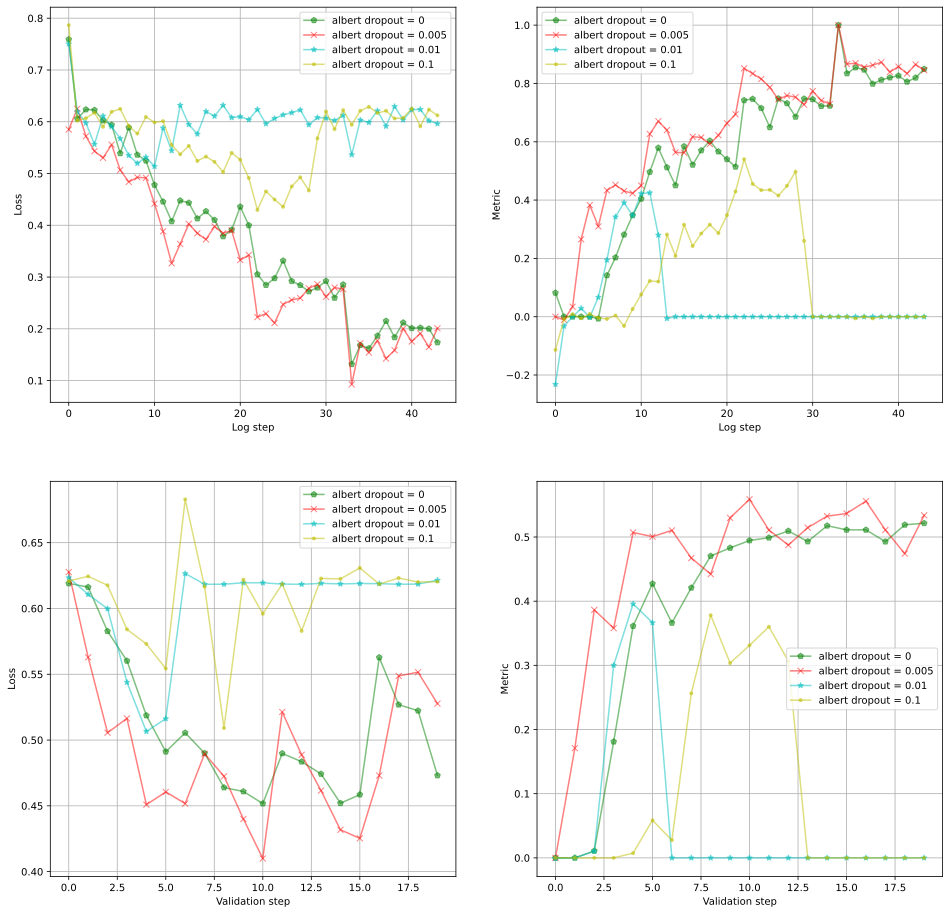

In [ ]:
plot_results(albert_loggers.values())

In [ ]:
with open('drop_distilbert_loggers','wb') as f:
    pickle.dump(distilbert_loggers, f )
with open('drop_distilroberta_loggers','wb') as f:
    pickle.dump(distilroberta_loggers, f )
with open('drop_albert_loggers','wb') as f:
    pickle.dump(albert_loggers, f )

## Посмотрим на результаты после подбора параметров

In [ ]:
with open('drop_distilbert_loggers','rb') as f:
    distilbert_loggers = pickle.load(f)
with open('drop_distilroberta_loggers','rb') as f:
    distilroberta_loggers = pickle.load(f)
with open('drop_albert_loggers','rb') as f:
    albert_loggers = pickle.load(f)

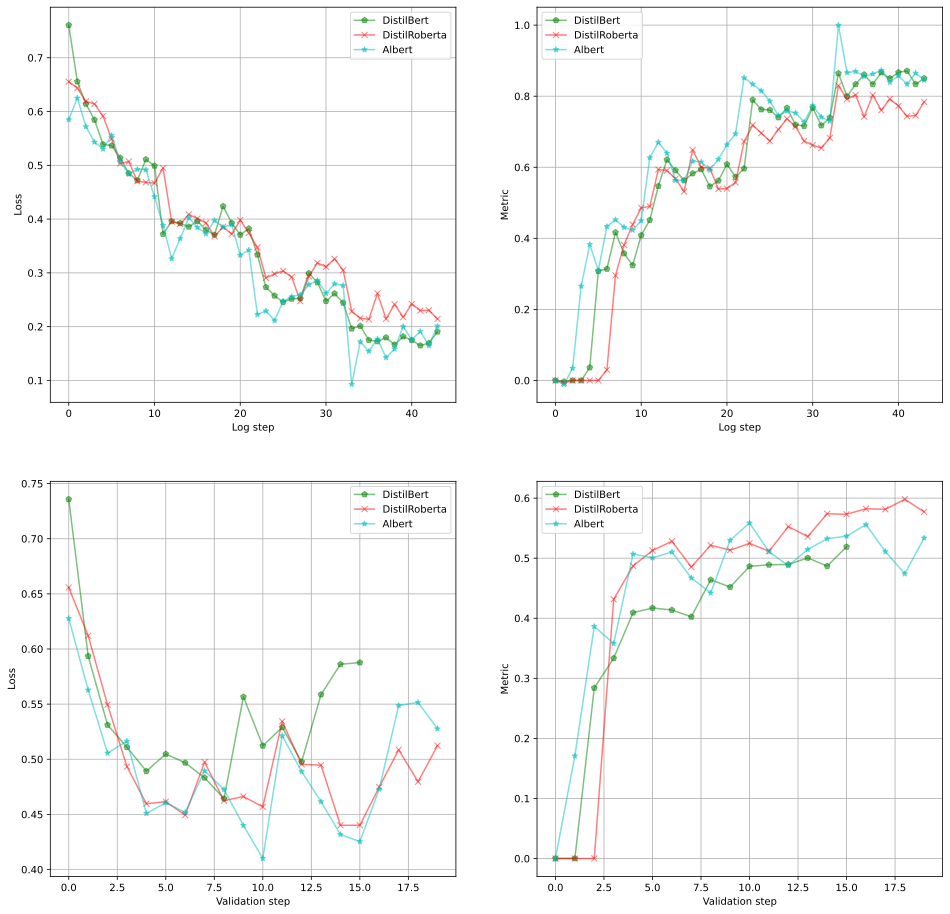

In [ ]:
distilbert_loggers[0.05].label = 'DistilBert'
distilroberta_loggers[0.05].label = 'DistilRoberta'
albert_loggers[0.005].label = 'Albert'
plot_results(
    [
        distilbert_loggers[0.05], 
        distilroberta_loggers[0.05],
        albert_loggers[0.005],
    ]
)

**Выводы:** в обычном файнтюне видно превосходство DistilRobert'ы, она самая большая из моделей (316MB), неожиданно вторым оказывается Albert, а третьим DistilBert. Несмотря на то, что в Albert'e в 8 раз меньше параметров он не сильно уступает DistilRobert'e и значительно превосходит DistilBert, который больше примерно в 7 раз (!!!). Таким образом, по соотношению размер/качество, очевидно, в данном эксперименте преимущество за Albert'ом.

## Попробуем тюнить только слой классификатора

В задачах CV (Computer Vision) тюна одного лишь слоя классификатора было достаточно для того, чтобы набрать хорошее качество, посмотрим, что получится в NLP.

In [ ]:
distilbert_loggers = dict()

for lr in [2e-5, 1e-5, 7e-6, 5e-6]:
    model, train_loader, valid_loader = prepare_model("distilbert-base-uncased", bs=128)

    weight_decay = 1e-3
    
    model = freeze_model(model) # Заморозим веса всех слоёв, кроме классификатора
    optim = torch.optim.AdamW(
        model.classifier.parameters(), 
        lr=lr, 
        weight_decay=weight_decay
    )
    
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                                step_size=100, 
                                                gamma=0.9)
    metric = HuggingMetric(matthew)
    logger = Logger(f'distilbert lr = {lr}')
    for epoch in range(NUM_EPOCH):
        train_epoch(
            model,
            optim,
            train_loader,
            valid_loader,
            logger,
            scheduler=scheduler,             
            metric=metric
        )
    clear_output()
    distilbert_loggers[lr] = logger
    

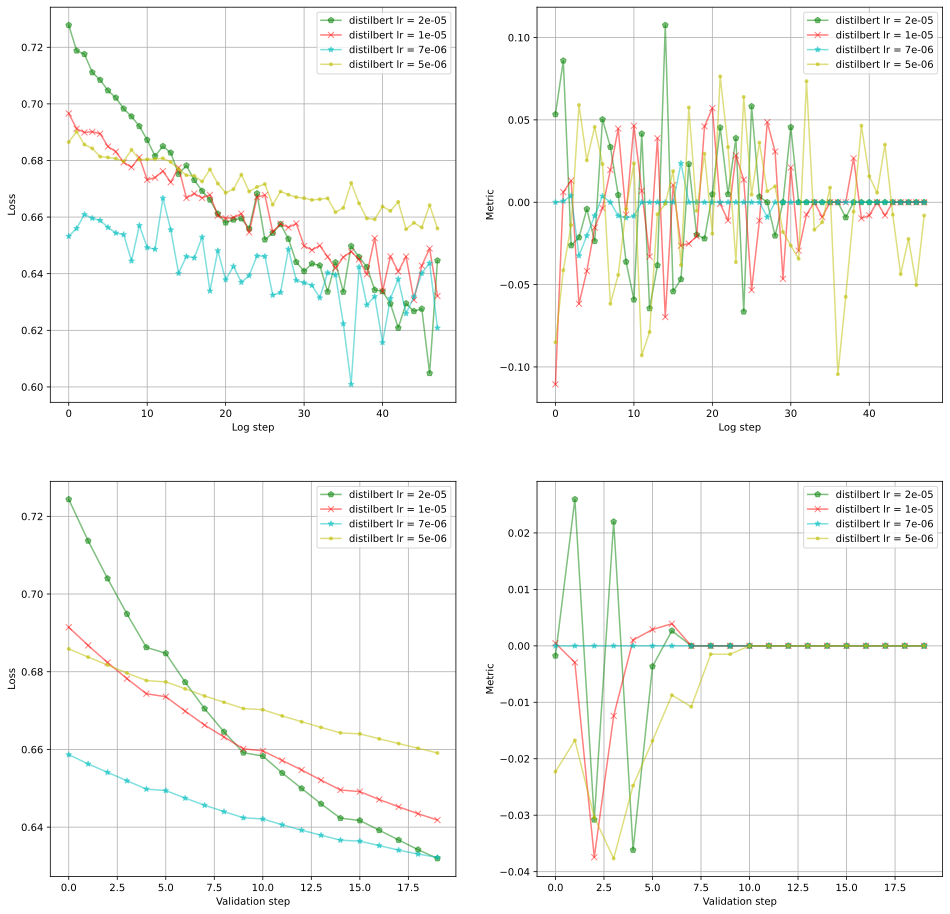

In [ ]:
plot_results(distilbert_loggers.values())

In [ ]:
distilroberta_loggers = dict()

for lr in [2e-5, 1e-5, 7e-6, 5e-6]:
    model, train_loader, valid_loader = prepare_model("distilroberta-base")

    weight_decay = 1e-3
    
    model = freeze_model(model)
    optim = torch.optim.AdamW(model.classifier.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                                step_size=2000, 
                                                gamma=0.9)
    metric = HuggingMetric(matthew)
    logger = Logger(f'distilroberta (cls) lr = {lr}')
    for epoch in range(NUM_EPOCH):
        train_epoch(
            model,
            optim,
            train_loader,
            valid_loader,
            logger,
            scheduler=scheduler,             
            metric=metric
        )
    clear_output()
    distilroberta_loggers[lr] = logger

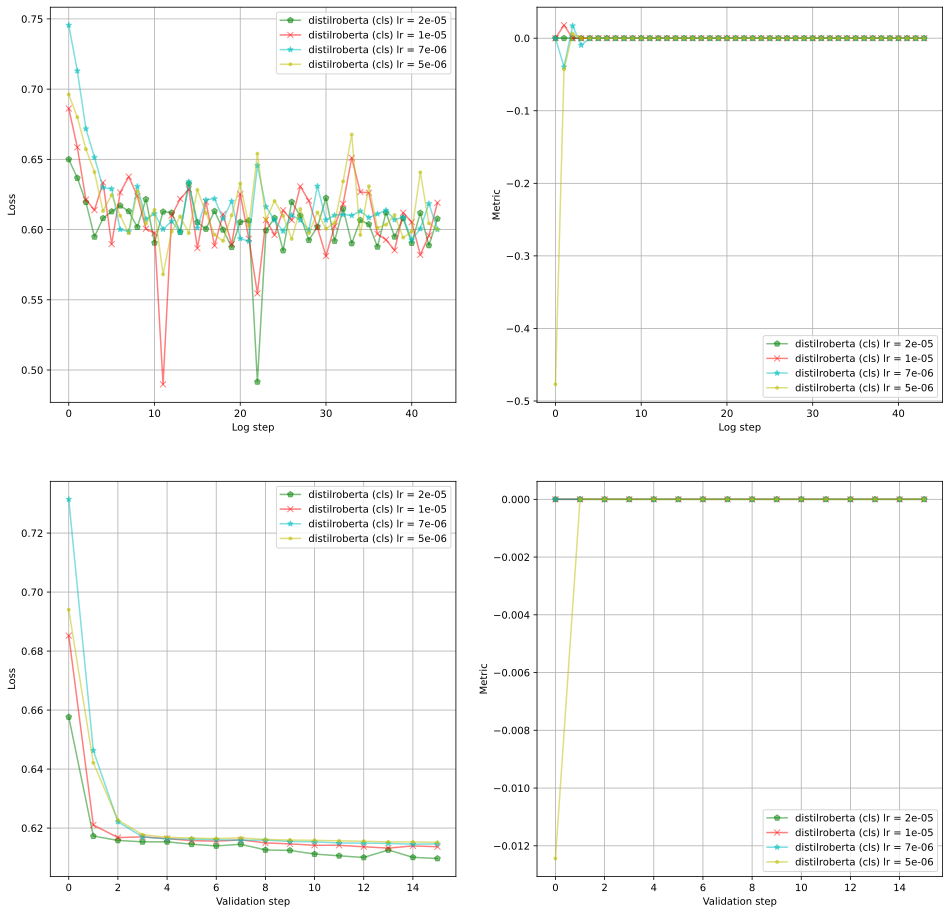

In [ ]:
plot_results(distilroberta_loggers.values())

In [ ]:
albert_loggers = dict()

for lr in [2e-5, 1e-5, 7e-6, 5e-6]:
    model, train_loader, valid_loader = prepare_model("albert-base-v2")

    weight_decay = 1e-3
    
    model = freeze_model(model)
    optim = torch.optim.AdamW(model.classifier.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                                step_size=100, 
                                                gamma=0.9)
    metric = HuggingMetric(matthew)
    logger = Logger(f'albert (cls) lr = {lr}')
    for epoch in range(NUM_EPOCH):
        train_epoch(
            model,
            optim,
            train_loader,
            valid_loader,
            logger,
            scheduler=scheduler,             
            metric=metric
        )
    clear_output()
    albert_loggers[lr] = logger

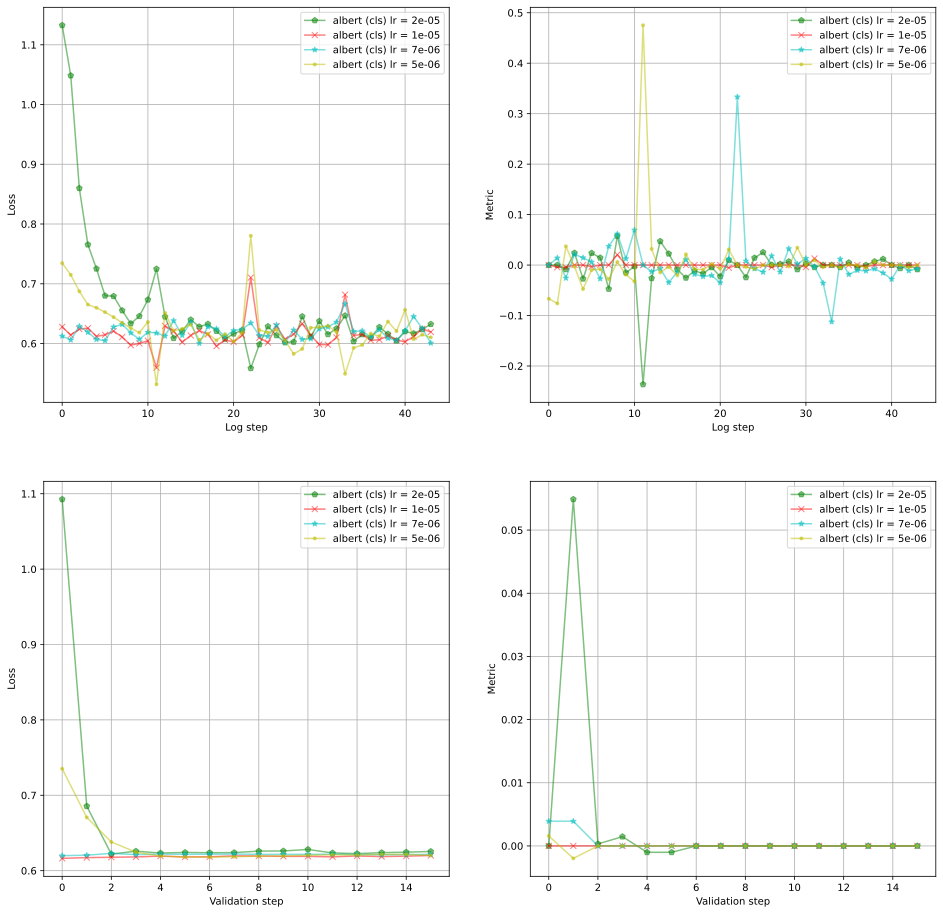

In [ ]:
plot_results(albert_loggers.values())

**Выводы**: дообучение одного лишь классификатора не приносит плодов ни одной модели, функциональной выразительности слоя классификатора не хватает для того, чтобы справляться с данной задачей, даже не смотря на то, что у DistilRobert'ы два полносвязных слоя в классификаторе. Дальнейшее сравнение не имеет смысла.


## Попробуем дистилляцию

Дистилляция как метод используется для того, чтобы получить знания большой модели маленькой, избегая долгого претрейна и пользуясь теми знаниями о языке, которые уже выучила большая модель. Ставка здесь идет на то, что большая модель из-за большого числа параметров обладает большей функциональной выразительностью и способна выучить более нетривиальные закономерности. Посмотрим так ли это в нашем случае?

In [ ]:
bert_loggers = dict()

train_pipeline(
    name = "bert-base-uncased", 
    lr = 1e-5,
    weight_decay = 1e-3,
    bs = 16, 
    drop = 0.1, 
    value = 1e-5,
    name_value = 'lr',
    loggers = bert_loggers,
)

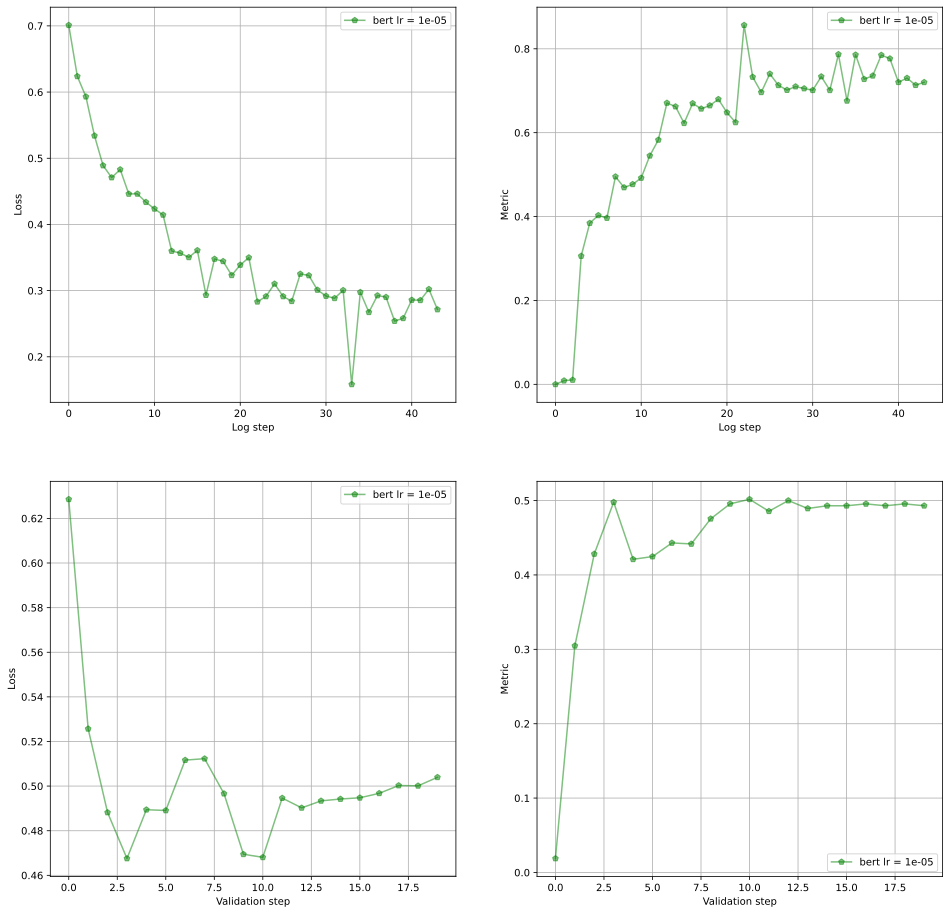

In [ ]:
plot_results(bert_loggers.values())

In [ ]:
with open('bert_loggers','wb') as f:
    pickle.dump(bert_loggers, f )

In [ ]:
distilbert_loggers = dict()

teacher_model = model

for alpha in [0.1, 0.5, 1, 5]:
    batch_size = 32
    drop = 0.05
    model, train_loader, valid_loader = prepare_model("distilbert-base-uncased", bs=batch_size, drop=drop)
    
    T = 5
    lr = 1e-5
    weight_decay = 1e-3

    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                                step_size=100, 
                                                gamma=0.9)
    metric = HuggingMetric(matthew)
    logger = Logger(f'distilbert alpha = {alpha}')
    for epoch in range(NUM_EPOCH):
        train_epoch_distil(
            alpha,
            T,
            model,
            teacher_model,
            optim,
            train_loader,
            valid_loader,
            logger,
            scheduler=scheduler,             
            metric=metric,
        )

    distilbert_loggers[alpha] = logger
    clear_output()

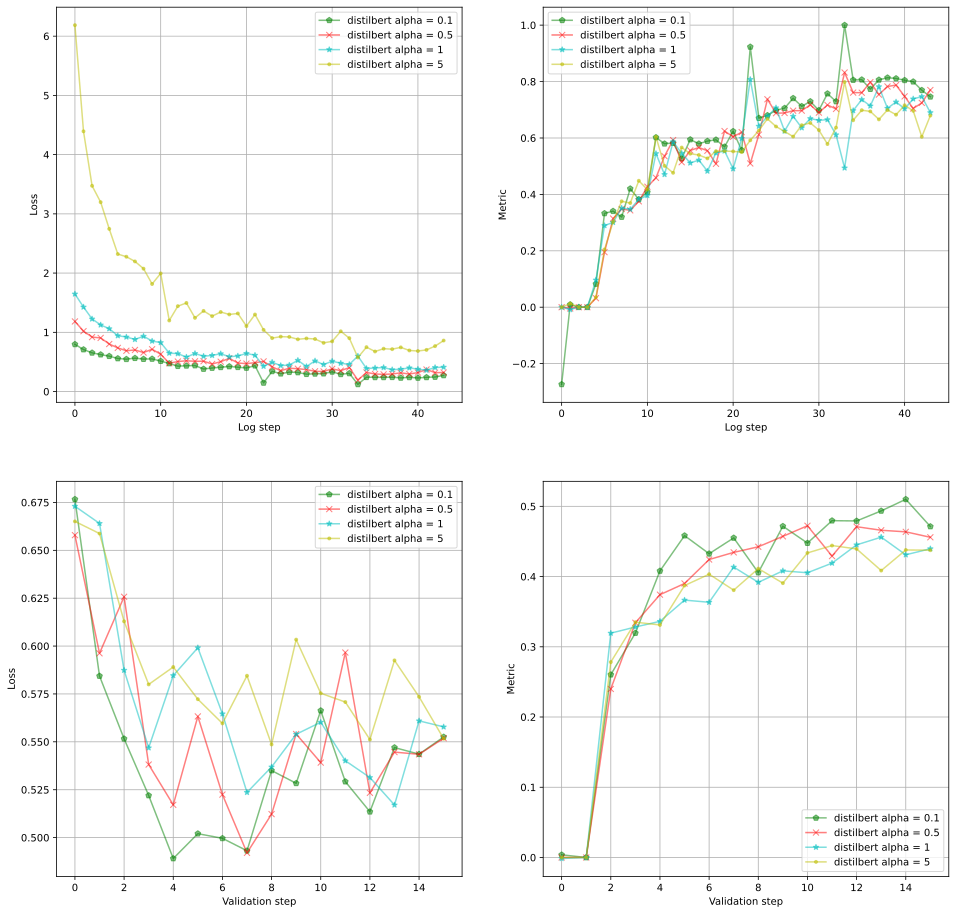

In [ ]:
plot_results(distilbert_loggers.values())

In [ ]:
with open('alpha_distilbert_loggers','wb') as f:
    pickle.dump(distilbert_loggers, f )

In [ ]:
roberta_loggers = dict()

train_pipeline(
    name = "roberta-base", 
    lr = 2e-5,
    weight_decay =  1e-1,
    bs = 32, 
    drop = 0.1, 
    value = 2e-5,
    name_value = 'lr',
    loggers = roberta_loggers
)

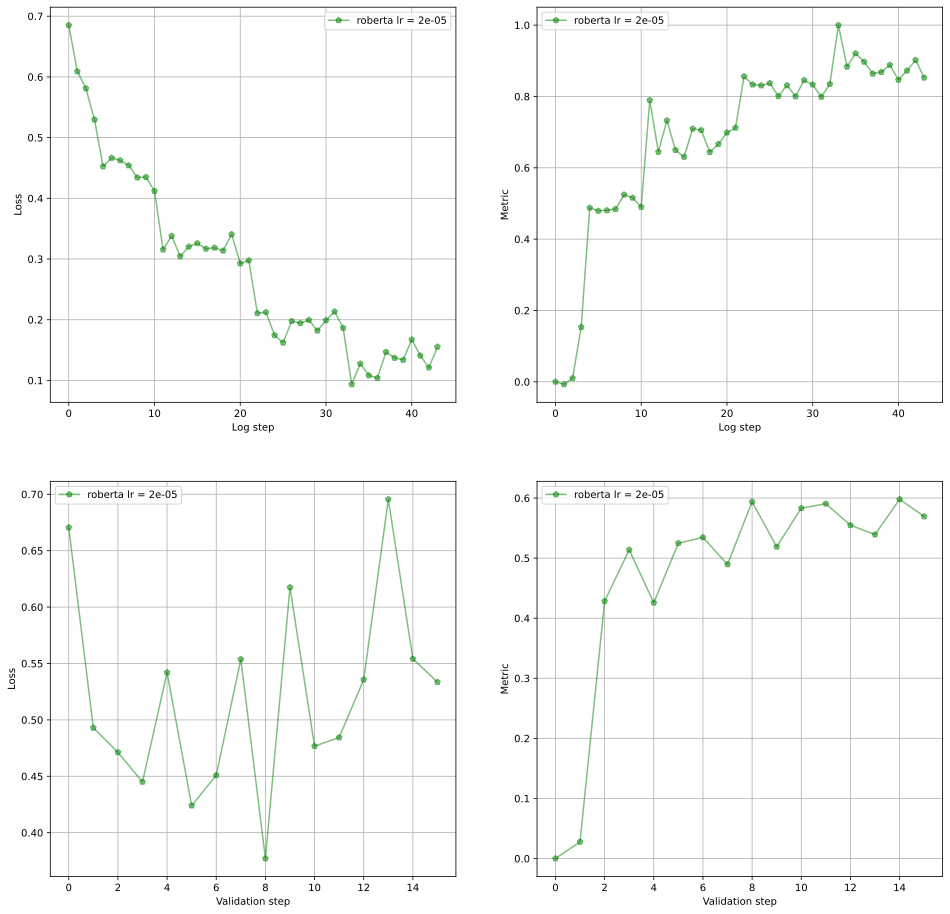

In [ ]:
plot_results(roberta_loggers.values())

In [ ]:
with open('roberta_loggers','wb') as f:
    pickle.dump(roberta_loggers, f )

In [ ]:
distilroberta_loggers = dict()

teacher_model = model

for alpha in [0.1, 0.5, 1, 5]:
    batch_size = 32
    drop = 0.05
    model, train_loader, valid_loader = prepare_model("distilroberta-base", bs=batch_size, drop=drop)
    
    T = 5
    lr = 1e-5
    weight_decay = 1e-1

    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                                step_size=100, 
                                                gamma=0.9)
    metric = HuggingMetric(matthew)
    logger = Logger(f'distilroberta alpha = {alpha}')
    for epoch in range(NUM_EPOCH):
        train_epoch_distil(
            alpha,
            T,
            model,
            teacher_model,
            optim,
            train_loader,
            valid_loader,
            logger,
            scheduler=scheduler,             
            metric=metric,
        )

    distilroberta_loggers[alpha] = logger
    clear_output()

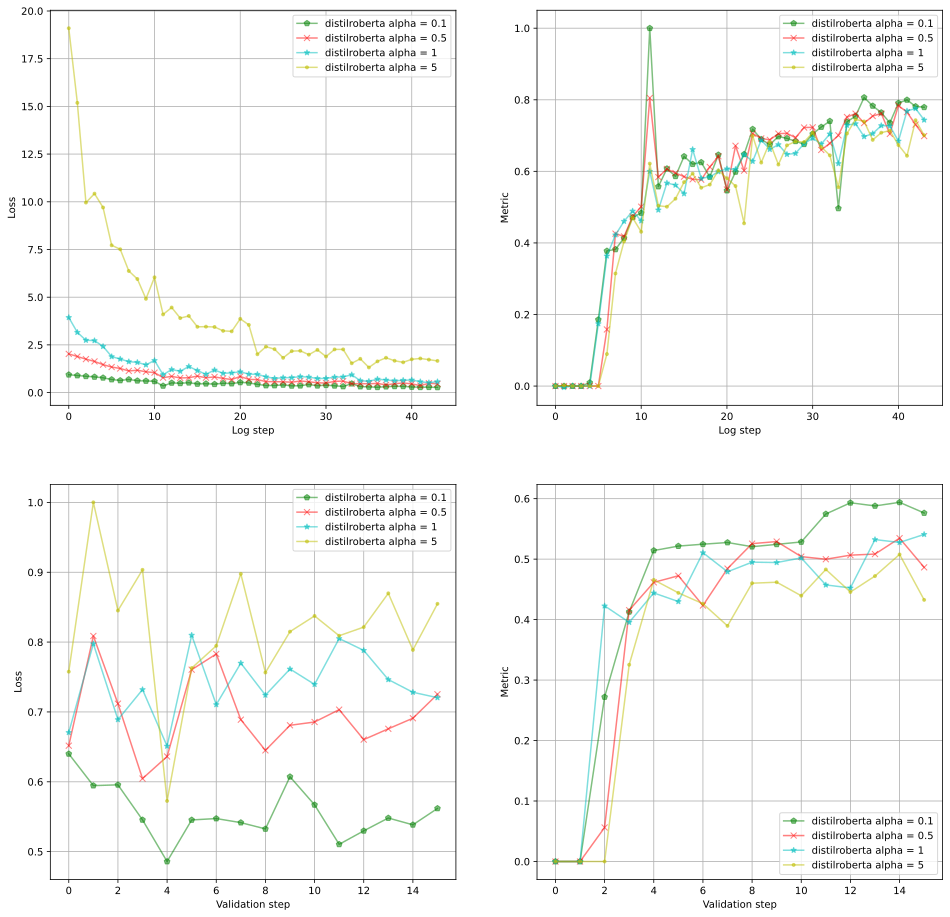

In [ ]:
plot_results(distilroberta_loggers.values())

In [ ]:
with open('alpha_distilroberta_loggers','wb') as f:
    pickle.dump(distilroberta_loggers, f )

In [ ]:
with open('bert_loggers','rb') as f:
    bert_logger = pickle.load(f)
    
with open('roberta_loggers','rb') as f:
    roberta_logger = pickle.load(f)

### Посмотрим на то, как обучились 'старшие' модели

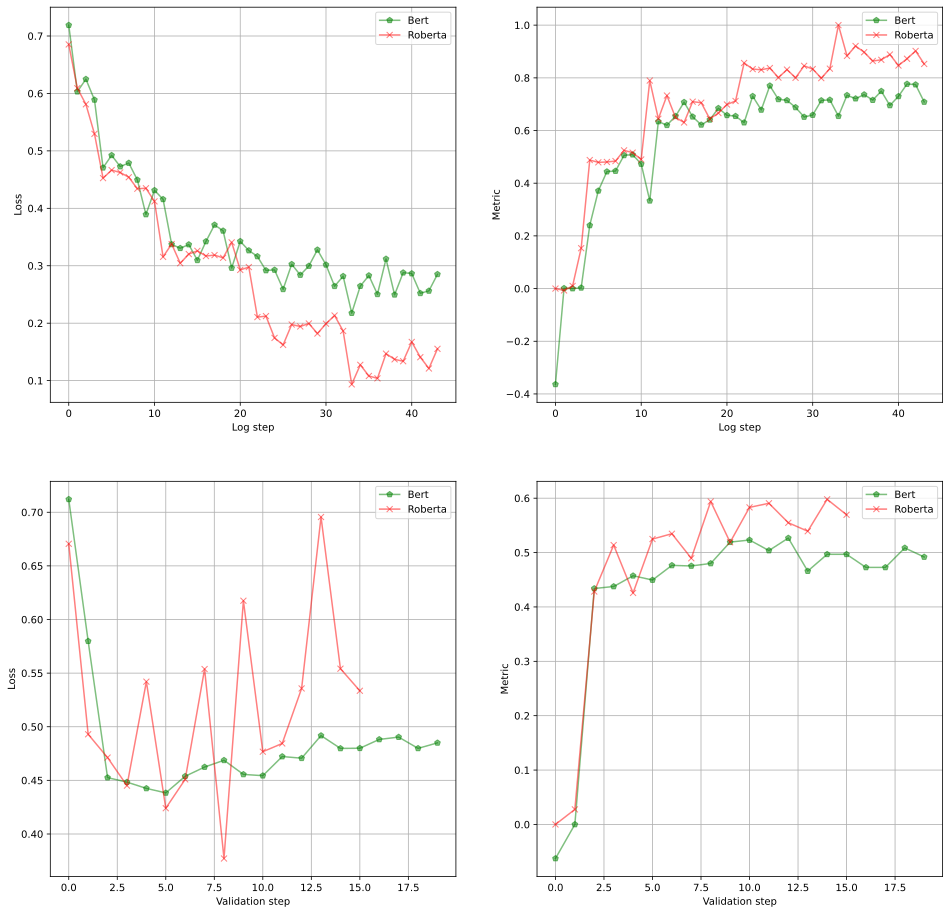

In [ ]:
bert_logger[1e-5].label = 'Bert'
roberta_logger[2e-5].label = 'Roberta'
plot_results([bert_logger[1e-5], roberta_logger[2e-5]])

**Выводы**: приведенные графики соотносятся с тем, что указывали авторы статей.

In [ ]:
with open('alpha_distilbert_loggers','rb') as f:
    distil_distilbert_logger = pickle.load(f)
    
with open('alpha_distilroberta_loggers','rb') as f:
    distil_distilroberta_logger = pickle.load(f)

### Посмотрим на сравнение 'старших' и  'младших моделей'.

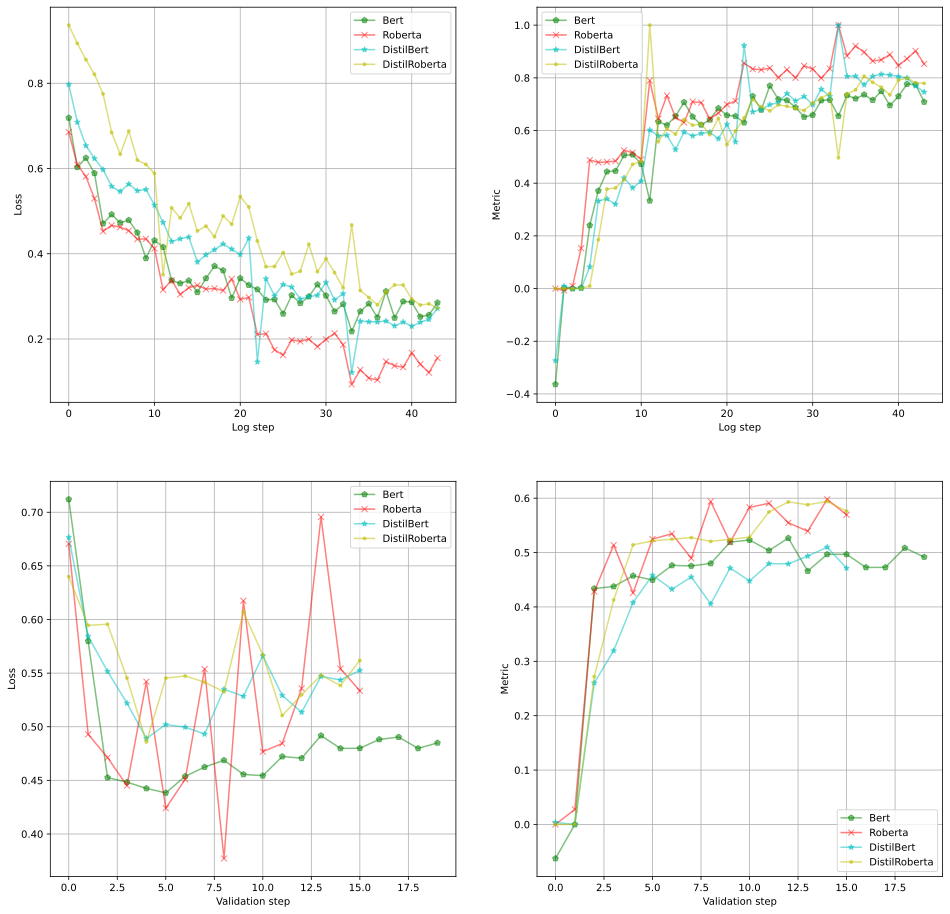

In [ ]:
bert_logger[1e-5].label = 'Bert'
roberta_logger[2e-5].label = 'Roberta'
distil_distilbert_logger[0.1].label = 'DistilBert'
distil_distilroberta_logger[0.1].label = 'DistilRoberta'
plot_results([
    bert_logger[1e-5], 
    roberta_logger[2e-5], 
    distil_distilbert_logger[0.1], 
    distil_distilroberta_logger[0.1]
])

**Выводы**: видим, что, в целом, 'младшие' модели после дистилляции практически не уступают 'старшим', возможно, это эффект от дистилляции, а может и дело в том, что изначально базовые модели достаточно хорошо предобученны. Посмотрим на следующей иллюстрации.

In [ ]:
with open('drop_distilbert_loggers','rb') as f:
    distilbert_loggers = pickle.load(f)
with open('drop_distilroberta_loggers','rb') as f:
    distilroberta_loggers = pickle.load(f)
with open('drop_albert_loggers','rb') as f:
    albert_loggers = pickle.load(f)

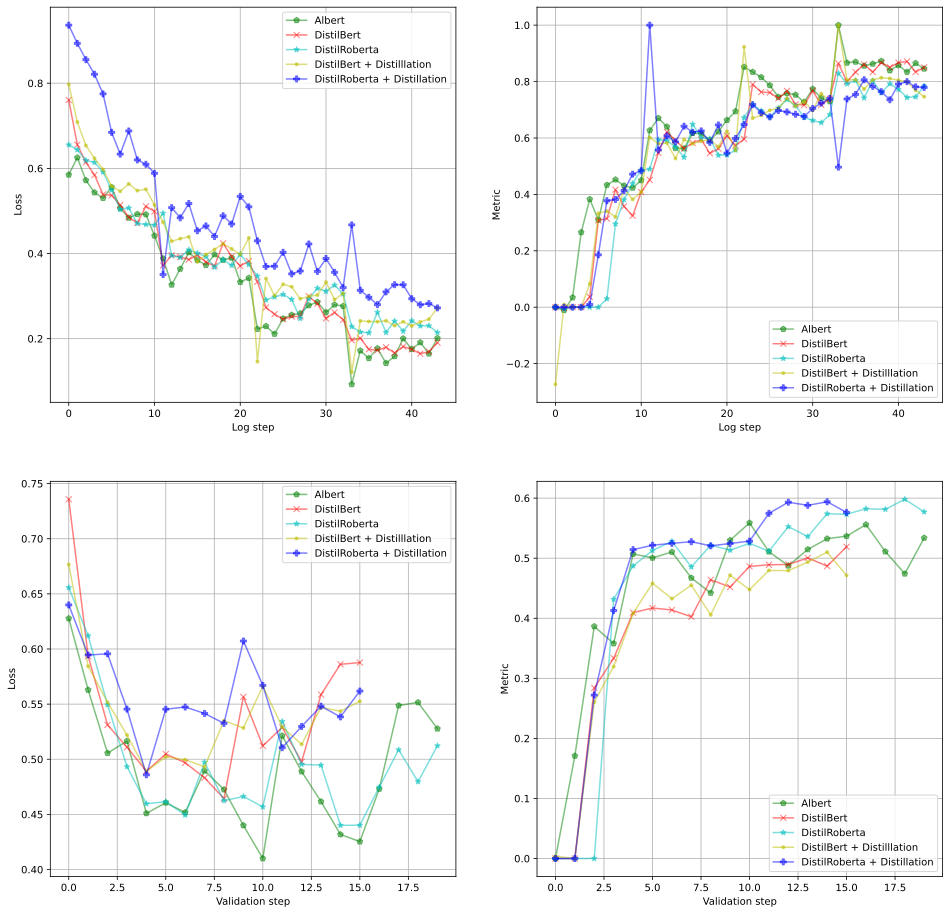

In [ ]:
albert_loggers[0.005].label = 'Albert'
distilbert_loggers[0.05].label = 'DistilBert'
distilroberta_loggers[0.05].label = 'DistilRoberta'
distil_distilbert_logger[0.1].label = 'DistilBert + Distilllation'
distil_distilroberta_logger[0.1].label = 'DistilRoberta + Distillation'
plot_results([
    albert_loggers[0.005],
    distilbert_loggers[0.05], 
    distilroberta_loggers[0.05], 
    distil_distilbert_logger[0.1], 
    distil_distilroberta_logger[0.1]
])

**Выводы**: Видим, что, на самом деле, предобученные модели хорошо решают задачу и без дистилляции, какого-то эффекта от нее усмотреть сложно, возможно, это связано с тем, что в данной задаче качество 'Bert' и 'Roberta' не сильно отличается от 'младших' моделей. При этом ресурсов на тренировку с дистилляцией потребуется, очевидно, больше, ведь нам надо испоьзовать 'старшую' версию трансформера.

# Заключение

Мы протестировали три разных трансформера `DistilBert`,  `DistilRoberta` и `Albert`. Их выбор был обусловлен их размером, все они относительно небольшие и компактные, легко обучаются, не требуя много ресурсов, и вполне сойдут за сильную бейзлайн-модель при решении задачи. Мы попробовали три разных подхода для дообучения этих нейросетей: обычный файнтюн всей сети, дообучение только слоя классификатора и дистилляцию. По результатам экспериментов можно сделать следующие выводы:
* Дообучение одного лишь слоя классификатора недостаточно для того, чтобы как-то решить сложную задачу, необходимо тренировать всю сеть целиком.
* Дистилляция более грузных и тяжелых сетей не помогает улучшить качество модели в данной задаче, так как качество на 'cтарших' моделей не сильно отличается.
* Хороший подбор параметров помогает достичь неплохих результатов на 'младших' версиях и даже сравняться со 'старшими'.
* Cамой удачной моделью в сравнении оказалась `Albert`, благодаря своим малым   размерам и хорошему качеству пальма первенства за ней.